# My Clustering Project
### Which neighborhoods should I visit on my trip to Seattle?

## Part I - Introduction

My sister moved to Seattle before the pandemic and I *still* haven't been able to visit her. I hope I'll be able to someday soon. In the meantime, I'm going to go ahead and figure out where to visit when I do get a chance to go. Seattle is a big city, so I'll narrow down my search by first determining which of the many neighborhoods in Seattle I'd like to stay in or visit. To do this, I'll compare each neighborhood to some of my favorite vacation destinations over the last decade using clustering and data from Foursquare. The result will help me place each district within the context of my previous vacations and best select the neighborhoods to visit.

My source data will come in two forms: location data for my previous vacations and the Seattle neighborhoods and venue data from Foursquare for each neighborhood/destination. The data from the vacation destinations will be transformed and a cluster analysis will be conducted. After a suitable model has been chosen, the Seattle district data will be scored. The results will illustrate similarities between each district and destinations I've visited in previous travels. I will then select a handful of neighborhoods to visit or stay in.

In [1]:
# import packages
import pandas as pd
import folium
import os
import requests
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

## Part II - Data

My source data is a hand-crafted list of 47 neighborhoods I have visited on previous trips and vacations.  It includes the name of the neighborhood, municipality, region, country, latitude, and longitude.  I will import the data and then prepare it for kmeans processing using one hot encoding, standardization, and principal component scoring.

Below is the break out of Region and Country for my previous vacations as well as a map with pins for each neighborhood.

In [2]:
# import my vacation data and inspect
vacation = pd.read_csv('./data/vacation_geo.csv')
vacation['Name'] = vacation[['Neighborhood', 'Municipality', 'Region', 'Country']].agg(', '.join, axis=1)

# check location data
vacation[['Region','Country']].value_counts()

Region          Country
Ontario         Canada     11
Georgia         USA         5
Quebec          Canada      5
Colorado        USA         4
Florida         USA         4
Tokyo           Japan       4
California      USA         3
Kyoto           Japan       2
South Carolina  USA         2
Tennessee       USA         2
Alabama         USA         1
Louisiana       USA         1
Nara            Japan       1
Osaka           Japan       1
Yamanashi       Japan       1
dtype: int64

In [3]:
# visualize vacation locations
latitude = vacation.lat.mean()
longitude = (vacation.lon.max() + vacation.lon.min())/2
map_geo = folium.Map(location=[latitude, longitude], zoom_start=2)

# add markers to map
for lat, lng, name in zip(vacation['lat'], 
                          vacation['lon'],
                          vacation['Name']):
    label = '{}'.format(name)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_geo)  
    
map_geo

In [4]:
# set foursquare credentials and version
CLIENT_ID = os.getenv('FOURSQUARE_CLIENT_ID')
CLIENT_SECRET = os.getenv('FOURSQUARE_CLIENT_SECRET')
VERSION = '20180605'
LIMIT = 100

In [5]:
# define function to pull venue information
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Name', 
                  'Name Latitude', 
                  'Name Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

The next step in my data preparation journey is to pull venue data from FourSquare for each neighborhood.

In [7]:
# call function to get venue information
vacation_venues = getNearbyVenues(names=vacation['Name'],
                                 latitudes=vacation['lat'],
                                 longitudes=vacation['lon']
                                )
print("All done getting venue data from FourSquare!")

All done getting venue data from FourSquare!


A few observations about the venue data:

In [8]:
# inspect venue data
print('There are {} unique venue categories.\n'.format(len(vacation_venues['Venue Category'].unique())))
print("Lots of coffee shops!")
print(vacation_venues['Venue Category'].describe(),'\n')
t = vacation_venues['Venue Category'].value_counts(normalize=True)
n = vacation_venues['Venue Category'].value_counts()
print("And cafes...")
print(n.head(10),'\n')

There are 317 unique venue categories.

Lots of coffee shops!
count            2803
unique            317
top       Coffee Shop
freq              140
Name: Venue Category, dtype: object 

And cafes...
Coffee Shop            140
Café                   123
Hotel                  114
Japanese Restaurant     75
Bar                     68
Pizza Place             55
Italian Restaurant      54
Restaurant              47
Bakery                  40
American Restaurant     38
Name: Venue Category, dtype: int64 



Now that that's sorted, time to start the feature engineering process by converting the venue category information to dummy variables using one hot encoding.

Note that the number of venues per neighborhood varies pretty dramatically.

In [9]:
# derive features with one hot encoding
vacation_onehot = pd.get_dummies(vacation_venues[['Venue Category']], prefix="", prefix_sep="")

# add Name column back to dataframe
vacation_onehot['Name'] = vacation_venues['Name'] 

# move Name column to the first column
fixed_columns = [vacation_onehot.columns[-1]] + list(vacation_onehot.columns[:-1])
vacation_onehot = vacation_onehot[fixed_columns]

name_counts = vacation_onehot.Name.value_counts().reset_index()
name_counts.columns = ['Name', 'Count']
q = name_counts[['Count']].quantile([0,0.05,0.1,0.25,0.33,0.5,0.67,0.75,0.9,0.95,1])
vacation_hot_counts = vacation_onehot.merge(name_counts, on='Name')

print('Some locations have as few as', q.loc[0, :][0], 'venues')
print('Some have up to', q.loc[1.00, :][0])
print('The median is', q.loc[0.50, :][0])

Some locations have as few as 2.0 venues
Some have up to 100.0
The median is 58.0


I will now determine the percent of venues that fall under each venue category by taking the mean of each venue category dummy variable and then standardize. This concludes the Data section of the report.

In [10]:
# group by Name and take mean by venue type
vacation_grouped = vacation_hot_counts.groupby('Name').mean().reset_index()

In [11]:
# standardize values
mask = vacation_grouped.Count > 19
X = vacation_grouped[mask].drop('Name', 1)
X = np.nan_to_num(X)
pca_dataset = StandardScaler().fit_transform(X)

## Part 3 - Methodology
The main methods used in this project will be principal component analysis (PCA) and the k-means clustering algorithm. 

Principal component analysis is used to reduce the number of inputs from 317 unique venue categories to a smaller, more manageable number of components.  More details on PCA analysis can be found on the Wikipedia page here: https://en.wikipedia.org/wiki/Principal_component_analysis.

Kmeans will then be used to cluster the vacation neighborhoods using the selected PCA components as input.  The trained model will be retained for scoring the Seattle neighborhood data.

Finally, the Seattle neighborhood data will be loaded, processed, scored, and analyzed.

The first 18 PCA components account for two-thirds of the variation in the 317 unique venue categories.
           0    cumsum
0   0.060794  0.060794
1   0.047451  0.108244
2   0.045818  0.154063
3   0.044783  0.198846
4   0.042983  0.241829
5   0.040027  0.281856
6   0.038500  0.320356
7   0.037761  0.358116
8   0.036341  0.394457
9   0.035387  0.429844
10  0.032426  0.462270
11  0.032264  0.494534
12  0.030947  0.525481
13  0.030225  0.555706
14  0.028725  0.584431
15  0.028598  0.613028
16  0.027849  0.640878
17  0.027460  0.668338 

I will select the first 18 PCA components as the k-means algorithm input.


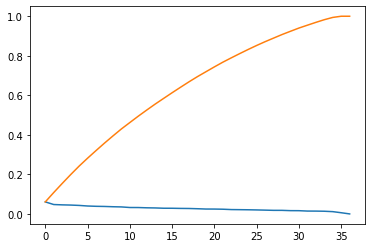

In [12]:
# run a principal component analysis
pca = PCA()
pca.fit(pca_dataset)
pca_comps = pd.DataFrame(pca.components_)
pca_comps['Name'] = vacation_grouped['Name'] 
pca_plot = pca_comps.iloc[:, [-1, 0, 1]]
pca_var = pd.DataFrame(pca.explained_variance_ratio_)
pca_var['cumsum'] = pca.explained_variance_ratio_.cumsum()
print("The first 18 PCA components account for two-thirds of the variation in the 317 unique venue categories.")
print(pca_var.head(18),'\n')
plt.plot(pca_var, '-')
print("I will select the first 18 PCA components as the k-means algorithm input.")

Next, I will fit a k-means model for a variety of different k values and select the k value that provides the best silhouette score. Details on silhouette score are here: https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html.

In [15]:
# determine best number of clusters
vacation_grouped_clustering = pca_comps.iloc[:, 0:18]
sil = []
for k in range(4, 11):
    kmeans = KMeans(n_clusters=k).fit(vacation_grouped_clustering)
    sil.append([silhouette_score(vacation_grouped_clustering, kmeans.labels_)])
    print("K: ",k)
    # Calculate silhouette_score
    print("Silhouette: ",silhouette_score(vacation_grouped_clustering, kmeans.labels_),"\n")

K:  4
Silhouette:  0.06326278842464582 

K:  5
Silhouette:  0.0593574545655956 

K:  6
Silhouette:  0.03404409318864639 

K:  7
Silhouette:  0.06973708401884836 

K:  8
Silhouette:  0.06881707468869878 

K:  9
Silhouette:  0.06889378747841537 

K:  10
Silhouette:  0.046154870629061165 



It looks like k = 7 provides the best silhouette score so will go with that. Now, time to fit the model with k = 6.

In [16]:
# fit a k-means using the selected number of clusters
kmeans = KMeans(n_clusters=7).fit(vacation_grouped_clustering)
print(pd.DataFrame(kmeans.labels_).value_counts())
print("Silhouette: ", silhouette_score(vacation_grouped_clustering, kmeans.labels_),"\n")

1    8
4    8
5    8
0    5
2    5
6    2
3    1
dtype: int64
Silhouette:  0.062482851802559136 



Finally, I will import the Seattle neighborhood data, process it, and run through the k-means model fit above.

In [17]:
# import seattle data
seattle = pd.read_csv('./data/seattle_geo.csv')
seattle['Name'] = seattle[['Neighborhood', 'Municipality', 'Region', 'Country']].agg(', '.join, axis=1)
print("Seattle data imported!")
print("There are",seattle.shape[0],"neighborhoods.")

Seattle data imported!
There are 17 neighborhoods.


Let's check out the map...

In [18]:
# visualize Seattle neighborhoods
latitude = seattle.lat.mean()
longitude = (seattle.lon.max() + seattle.lon.min())/2
map_geo = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, name in zip(seattle['lat'], 
                          seattle['lon'],
                          seattle['Name']):
    label = '{}'.format(name)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_geo)  
    
map_geo

Time to pull the venue data for Seattle from FourSquare.

In [19]:
# process the seattle venue data
seattle_venues = getNearbyVenues(names=seattle['Name'],
                                 latitudes=seattle['lat'],
                                 longitudes=seattle['lon']
                                )
print("All done pulling Seattle venue data!")

All done pulling Seattle venue data!


In [20]:
# inspect the seattle venues
print('There are {} unique venue categories in the Seattle data.'.format(len(seattle_venues['Venue Category'].unique())))

There are 219 unique venue categories in the Seattle data.


Next, as before, I apply one hot encoding to create the dummy variables then take the mean to get the percentage of venues in each category per neighborhood. The resulting columns are then standardized using the standard scaler fit to the vacations data.

In [21]:
# derive features with one hot encoding
seattle_onehot = pd.get_dummies(seattle_venues[['Venue Category']], prefix="", prefix_sep="")

# add Name column back to dataframe
seattle_onehot['Name'] = seattle_venues['Name'] 

# move Name column to the first column
fixed_columns = [seattle_onehot.columns[-1]] + list(seattle_onehot.columns[:-1])
seattle_onehot = seattle_onehot[fixed_columns]

name_counts = seattle_onehot.Name.value_counts().reset_index()
name_counts.columns = ['Name', 'Count']
q = name_counts[['Count']].quantile([0,0.05,0.1,0.25,0.33,0.5,0.67,0.75,0.9,0.95,1])
seattle_hot_counts = seattle_onehot.merge(name_counts, on='Name')
print('Some neighborhoods have as few as', q.loc[0, :][0], 'venues')
print('Some have up to', q.loc[1.00, :][0])
print('The median is', q.loc[0.50, :][0])

Some neighborhoods have as few as 7.0 venues
Some have up to 100.0
The median is 41.0


In [22]:
# group by Name and take mean by venue type
seattle_grouped = seattle_hot_counts.groupby('Name').mean().reset_index()

In [23]:
# standardize values
mask = vacation_grouped.Count > 19
X = vacation_grouped[mask].drop('Name', 1)
x_col = X.columns
X = np.nan_to_num(X)
stnd = StandardScaler().fit(X)
S = seattle_grouped.drop('Name', 1)
S = S.reindex(labels=x_col, axis=1)
S = np.nan_to_num(S)
seattle_stnd = stnd.transform(S)

The last step before scoring with k-means is to apply the PCA transformation that was fit using the vacation data above and keep the first 18 components.

In [24]:
# score the data with the pca fit above
seattle_pca = pca.transform(seattle_stnd)
seattle_comps = pd.DataFrame(seattle_pca)
seattle_comps['Name'] = seattle_grouped['Name'] 
seattle_grouped_clustering = seattle_comps.iloc[:, 0:18]
print("PCA scoring complete, time to run k-means!")

PCA scoring complete, time to run k-means!


In [25]:
# score the data with the kmeans fit above
seattle_clusters = kmeans.predict(seattle_grouped_clustering)

## Part IV - Results

Now it's time to take a look at the results of scoring the Seattle neighborhoods and compare with my previous vacation destinations.

In [28]:
# add clustering labels
seattle_labeled = seattle_comps.copy()
seattle_labeled.insert(0, 'Cluster Labels', seattle_clusters)
print("Distribution of Cluster Labels on the Seattle data:")
print(seattle_labeled['Cluster Labels'].value_counts())
print("\nFull listing of the clustered Seattle data:")
seattle_labeled.iloc[:, [0,-1]]

Distribution of Cluster Labels on the Seattle data:
1    4
3    4
4    3
0    2
2    2
6    2
Name: Cluster Labels, dtype: int64

Full listing of the clustered Seattle data:


,Cluster Labels,Name
0,3,"Ballard, Seattle, Washington, USA"
1,4,"Beacon Hill, Seattle, Washington, USA"
2,2,"Belltown, Seattle, Washington, USA"
3,2,"Capitol Hill, Seattle, Washington, USA"
4,6,"Central District, Seattle, Washington, USA"
5,0,"Chinatown-International, Seattle, Washington, USA"
6,1,"Downtown, Seattle, Washington, USA"
7,6,"Fremont, Seattle, Washington, USA"
8,3,"Georgetown, Seattle, Washington, USA"
9,3,"Lake City, Seattle, Washington, USA"


I'll combine the vacation data and Seattle data to look for similarities between neighborhoods.

In [29]:
# add clustering labels to the vacation data and combine with Seattle to make a comprehensive file
vacation_labeled = pca_comps.copy()
vacation_labeled.insert(0, 'Cluster Labels', kmeans.labels_)
combined_labeled = pd.concat([vacation_labeled.iloc[:,[0,-1]], seattle_labeled.iloc[:,[0,-1]]], ignore_index=True)

In [30]:
# combined cluster distribution
print("Distribution of Cluster Labels on the combined data:")
combined_labeled['Cluster Labels'].value_counts()

Distribution of Cluster Labels on the combined data:


1    12
4    11
5     8
0     7
2     7
3     5
6     4
Name: Cluster Labels, dtype: int64

Let's look at each cluster one at a time.

In [35]:
# cluster 0
print('Cluster 0')
mask0 = combined_labeled['Cluster Labels'] == 0
print(combined_labeled.loc[mask0])

Cluster 0
    Cluster Labels                                               Name
0                0           Alexandra Park, Toronto, Ontario, Canada
11               0               Downtown, Gatlinburg, Tennessee, USA
12               0                  Downtown, Memphis, Tennessee, USA
15               0                   Downtown, Ukiah, California, USA
33               0                        Minami, Osaka, Osaka, Japan
42               0  Chinatown-International, Seattle, Washington, USA
52               0              Wallingford, Seattle, Washington, USA


In [36]:
# cluster 1
print('Cluster 1')
mask0 = combined_labeled['Cluster Labels'] == 1
combined_labeled.loc[mask0, combined_labeled.columns[[0,-1]]]

Cluster 1


,Cluster Labels,Name
3,1,"Chinatown, Montreal, Quebec, Canada"
7,1,"Destin, Destin, Florida, USA"
8,1,"Distillery District, Toronto, Ontario, Canada"
17,1,"Financial District, Toronto, Ontario, Canada"
27,1,"Little Five Points, Atlanta, Georgia, USA"
28,1,"Little River, Little River, California, USA"
30,1,"Manitou Springs, Manitou Springs, Colorado, USA"
34,1,"Mountain Top, Mentone, Alabama, USA"
43,1,"Downtown, Seattle, Washington, USA"
47,1,"Pioneer Square, Seattle, Washington, USA"


In [37]:
# cluster 2
print('Cluster 2')
mask0 = combined_labeled['Cluster Labels'] == 2
combined_labeled.loc[mask0]

Cluster 2


,Cluster Labels,Name
13,2,"Downtown, Mendocino, California, USA"
16,2,"Entertainment District, Toronto, Ontario, Canada"
24,2,"Historic District, Savannah, Georgia, USA"
29,2,"Lodo, Denver, Colorado, USA"
31,2,"Midtown, Atlanta, Georgia, USA"
39,2,"Belltown, Seattle, Washington, USA"
40,2,"Capitol Hill, Seattle, Washington, USA"


In [38]:
# cluster 3
print('Cluster 3')
mask0 = combined_labeled['Cluster Labels'] == 3
combined_labeled.loc[mask0]

Cluster 3


,Cluster Labels,Name
36,3,"Old Montreal, Montreal, Quebec, Canada"
37,3,"Ballard, Seattle, Washington, USA"
45,3,"Georgetown, Seattle, Washington, USA"
46,3,"Lake City, Seattle, Washington, USA"
48,3,"Queen Anne, Seattle, Washington, USA"


In [39]:
# cluster 4
print('Cluster 4')
mask0 = combined_labeled['Cluster Labels'] == 4
combined_labeled.loc[mask0]

Cluster 4


,Cluster Labels,Name
2,4,"Casa Loma, Toronto, Ontario, Canada"
4,4,"Chinatown, Toronto, Ontario, Canada"
5,4,"Church and Wellesley, Toronto, Ontario, Canada"
9,4,"Downtown, Atlanta, Georgia, USA"
20,4,"Ginza, Chūō, Tokyo, Japan"
21,4,"Harbourfront, Toronto, Ontario, Canada"
25,4,"Kensington Market, Toronto, Ontario, Canada"
35,4,"Nara Park, Nara, Nara, Japan"
38,4,"Beacon Hill, Seattle, Washington, USA"
50,4,"SoDo, Seattle, Washington, USA"


In [40]:
# cluster 5
print('Cluster 5')
mask0 = combined_labeled['Cluster Labels'] == 5
combined_labeled.loc[mask0]

Cluster 5


,Cluster Labels,Name
1,5,"Asakusa, Taitō, Tokyo, Japan"
6,5,"Cinco Bayou, Fort Walton Beach, Florida, USA"
10,5,"Downtown, Charleston, South Carolina, USA"
18,5,"French Quarter, New Orleans, Louisiana, USA"
22,5,"Higashiyama, Kyoto, Kyoto, Japan"
23,5,"Highland, Denver, Colorado, USA"
26,5,"Lake Kawaguchi, Fujikawaguchiko, Yamanashi, Japan"
32,5,"Mile End, Montreal, Quebec, Canada"


In [41]:
# cluster 6
print('Cluster 6')
mask0 = combined_labeled['Cluster Labels'] == 6
combined_labeled.loc[mask0]

Cluster 6


,Cluster Labels,Name
14,6,"Downtown, Montreal, Quebec, Canada"
19,6,"Garden District, Toronto, Ontario, Canada"
41,6,"Central District, Seattle, Washington, USA"
44,6,"Fremont, Seattle, Washington, USA"


## 5 - Discussion

A few of my most favorite vacation destinations were:
* Downtown, Mendocino, California, USA: **Cluster 2**
* Ginza, Chūō, Tokyo, Japan: **Cluster 4**
* Minami, Osaka, Osaka, Japan: **Cluster 0**
* Nara Park, Nara, Nara, Japan: **Cluster 4**
* Historic District, Savannah, Georgia, USA: **Cluster 2**
* Church and Wellesley, Toronto, Ontario, Canada: **Cluster 4**
* Lodo, Denver, Colorado, USA: **Cluster 2**
* Mile End, Montreal, Quebec, Canada: **Cluster 5**

Therefore, I'll focus on clusters 2 and 4 and see which Seattle neighborhoods are similar.

In [49]:
print('Seattle Neighborhoods in Clusters 2 and 4:')
mask2 = seattle_labeled['Cluster Labels'] == 2
mask4 = seattle_labeled['Cluster Labels'] == 4
seattle_labeled.loc[mask2|mask4,['Name','Cluster Labels']]

Seattle Neighborhoods in Clusters 2 and 4:


,Name,Cluster Labels
1,"Beacon Hill, Seattle, Washington, USA",4
2,"Belltown, Seattle, Washington, USA",2
3,"Capitol Hill, Seattle, Washington, USA",2
13,"SoDo, Seattle, Washington, USA",4
14,"University District, Seattle, Washington, USA",4


Based on these results, I'm going to prioritize visiting Beacon Hill, Belltown, Capital Hill, SoDo, and University District on my trip to Seattle.  Time to start planning!!

## 6 - Conclusion
Well, that was fun!  I've imported neighborhood data from previous vacations as well as Seattle, my future vacation destination.  I then imported venue data from the FourSquare API and processed using one hot encoding, standardization, and principal component analysis.  Finally, I fit a kmeans clustering model to the vacation data and applied to the Seattle location data to come up with a short list of neighborhoods to visit on my trip to Seattle.  Honestly, I'll probably take recommendations from my sister as well.  She lives there after all!  Anyways, hope you enjoyed and thanks for reading through! :)